In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
#from tools.preprocess import preproc_maria,preproc_haiyan
sys.path.insert(1, '../')
import read_stuff as read
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/maria/parallel/')
import ts_models
import properscoring as ps
import benchmark
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
enter = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'

maria_u = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix)['u'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]
divider = np.asarray([maria_u[0][12:].shape[0],maria_u[1][25:].shape[0],maria_u[2][49:].shape[0],maria_u[3][85:].shape[0],maria_u[4][25:].shape[0]]).cumsum()

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
import glob
folder = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/timeseries/'#intermediate/'
Xtrain,Xvalid,Xtest,ytrain,yvalid,ytest = [],[],[],[],[],[]
for expname in [2,3,4]:
    obj = [read_and_proc.depickle(objs) for objs in sorted(glob.glob(folder+'inputoutput2/*val'+str(expname)))]
    Xtest.append(obj[0])
    Xtrain.append(obj[1])
    Xvalid.append(obj[2])
    ytest.append(obj[3])
    ytrain.append(obj[4])
    yvalid.append(obj[5])

TYPE = '3D'
if TYPE=='3D':
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/'
    pcastore = read_and_proc.depickle(folderpath+'PCA/PCAdict3D')
elif TYPE=='2D':
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/maria/processed/intermediate/'
    pcastore = read_and_proc.depickle(folderpath+'PCA/PCAdict')

In [4]:
maria_lw = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/preproc2/'+str(lime)+suffix+'_radcomp')['LW'] for lime in tqdm(['ctl','ncrf_36h','ncrf_60h','ncrf_96h','lwcrf'])]

  0%|          | 0/5 [00:00<?, ?it/s]

# Model

In [5]:
class OptimMLR_lwsw_3D_ts_dropout(torch.nn.Module):
    def __init__(self,droprate):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_lwsw_3D_ts_dropout, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [10,10]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dropout1 = torch.nn.Dropout(droprate)
        self.dropout2 = torch.nn.Dropout(droprate)
        self.dropout3 = torch.nn.Dropout(droprate)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,1)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,54,26,50,75,12,10,10]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        print(X_lw.shape)
        ############################################################
        # Optimal PC layer
        ############################################################
        X_lwc = self.dropout1(X_lw)
        bestlw = self.dense1(X_lwc)
        X_swc = self.dropout2(X_sw)
        bestsw = self.dense2(X_swc)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        bestPC = self.dropout3(bestPC)
        outpred = self.denseout(bestPC)
        return outpred
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

# Performance

In [5]:
def model_outweights(model=None):
    params,names = [],[]
    for name, param in model.named_parameters():
        if ".weight" not in name:
            continue
        else:
            params.append(param)
            names.append(name)
    return params, names

def grab_predictions(model=None,Xtensors=None,trial=20,TYPE='all'):
    if TYPE=='all':
        return [np.squeeze(model.train()(Xtensors).detach().numpy().transpose()) for i in range(trial)],np.nanmean(np.asarray([np.squeeze(model.train()(Xtensors).detach().numpy().transpose()) for i in range(trial)]),axis=0)
    elif TYPE=='Drop1_2':
        model.dropout1.train()
        model.dropout2.train()
        storeweights = [model_outweights(model) for i in range(trial)]
        return [np.squeeze(model(Xtensors).detach().numpy().transpose()) for i in range(trial)],np.nanmean(np.asarray([np.squeeze(model(Xtensors).detach().numpy().transpose()) for i in range(trial)]),axis=0),storeweights
    
def get_meanr2(X=None,y=None):
    return r2_score(y,X)
def get_meanrmse(X=None,y=None):
    return np.sqrt(mean_squared_error(y,X))
def get_meanmae(X=None,y=None):
    return mean_absolute_error(y,X)

def get_performances(folderpath=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'),
                     folderpath2=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'),
                     droprate=None,Xtrain=None,Xvalid=None,ytrain=None,yvalid=None,metric='r2',trailnums=50,withspread=False):
    trailnums = trailnums
    allstoredicts_drop1_2 = []
    for splitnum in tqdm(range(3)):
        X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[splitnum],ytrain[splitnum])#yall_orig[splitnum][23][0])
        X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[splitnum],yvalid[splitnum])#yall_orig[splitnum][23][1])
        X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[splitnum],ytest[splitnum])#yall_orig[splitnum][23][1])
        calc_device = 'cpu'
        ###################################################################################
        # Convert numpy arrays into tensors
        ###################################################################################
        train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
        train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
        val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
        val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
        test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
        test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
        
        models = [torch.load(obj) for obj in glob.glob('./models/1d/mcdrop2/'+str(droprate)+'/'+str(int(splitnum))+'/modelstest'+str(splitnum)+'_*')]
        #models = [torch.load(obj) for obj in sorted(glob.glob('./models/1d/mcdrop2/'+str(int(splitnum+2))+'/models*'))]
        
        alltrains,meantrains,allvals,meanvals,alltests,meantests,r2trains,r2vals,r2tests,weights = [],[],[],[],[],[],[],[],[],[]
        spreaddicts,truth = [],[]
        for model in models:
            alltrain,meantrain,weight_train = grab_predictions(model[0],train_Xtensor,trailnums,'Drop1_2')
            allval,meanval,weight_val = grab_predictions(model[0],val_Xtensor,trailnums,'Drop1_2')
            alltest,meantest,weight_test = grab_predictions(model[0],test_Xtensor,trailnums,'Drop1_2')
            # Plotting
            #plt.fill_between(np.linspace(0,len(meantrain)-1,len(meantrain)),
            #                 meantrain-np.std(np.asarray(alltrain),axis=0),meantrain+np.std(np.asarray(alltrain),axis=0),alpha=0.1,color='r')
            #plt.plot(meantrain,lw=2.13,alpha=0.93,c='r')
            #plt.plot(y_totrain)
            #plt.show()
            if metric=='r2':
                meanr2_train = get_meanr2((meantrain),(y_totrain))
                meanr2_val = get_meanr2((meanval),(y_tovalid))
                meanr2_test = get_meanr2((meantest),(y_totest))
            elif metric=='rmse':
                meanr2_train = get_meanrmse(meantrain,y_totrain)
                meanr2_val = get_meanrmse(meanval,y_tovalid)     
                meanr2_test = get_meanrmse(meantest,y_totest)
            elif metric=='mae':
                meanr2_train = get_meanmae(meantrain,y_totrain)
                meanr2_val = get_meanmae(meanval,y_tovalid)
                meanr2_test = get_meanmae(meantest,y_tovalid)
            elif metric=='crps':
                meanr2_train = ps.crps_ensemble(np.asarray(y_totrain).transpose(),np.asarray(alltrain).transpose()).mean()
                meanr2_val = ps.crps_ensemble(np.asarray(y_tovalid).transpose(),np.asarray(allval).transpose()).mean()
                meanr2_test = ps.crps_ensemble(np.asarray(y_totest).transpose(),np.asarray(alltest).transpose()).mean()
            if withspread:
                meanstd_train = np.std(np.asarray(alltrain),axis=0)
                meanstd_val = np.std(np.asarray(allval),axis=0)
                meanstd_test = np.std(np.asarray(alltest),axis=0)
                meanstd_dict = {'train':meanstd_train,'valid':meanstd_val,'test':meanstd_test}
            else:
                continue
                
            alltrains.append(alltrain)
            meantrains.append(meantrain)
            allvals.append(allval)
            meanvals.append(meanval)
            alltests.append(alltest)
            meantests.append(meantest)
            r2trains.append(meanr2_train)
            r2vals.append(meanr2_val)
            r2tests.append(meanr2_test)
            weights.append({'train':weight_train,'val':weight_val,'test':weight_test})
            spreaddicts.append(meanstd_dict)
            truth.append({'train':y_totrain,'valid':y_tovalid,'test':y_totest})
        
        allstoredicts_drop1_2.append({'models':models,'alltrains':alltrains,'meantrains':meantrains,'allvals':allvals,'meanvals':meanvals,'alltests':alltests,'meantests':meantests,'r2trains':r2trains,'r2vals':r2vals,'r2tests':r2tests,'weights':weights,'spreads':spreaddicts,'truth':truth})
    return allstoredicts_drop1_2

In [6]:
import properscoring as ps
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

droprates = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
crps_store = {droprate: get_performances(folderpath=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'),
                     folderpath2=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'),
                     droprate=droprate,Xtrain=Xtrain,Xvalid=Xvalid,ytrain=ytrain,yvalid=yvalid,metric='crps',trailnums=50,withspread=True) for droprate in droprates}
r2_store = {droprate: get_performances(folderpath=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/'),
                     folderpath2=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'),
                     droprate=droprate,Xtrain=Xtrain,Xvalid=Xvalid,ytrain=ytrain,yvalid=yvalid,metric='r2',trailnums=50,withspread=True) for droprate in droprates}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
[obj for obj in crps_store]

[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

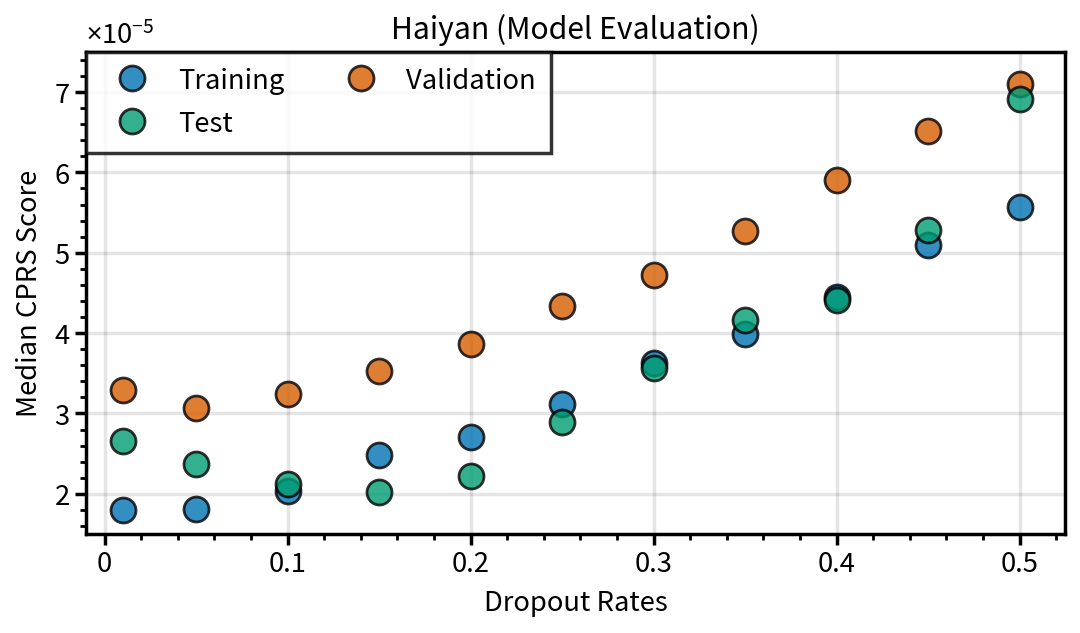

In [8]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=2.031)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([crps_store[droprate][i]['r2trains'] for i in range(3)])) for droprate in droprates],lw=0,label='Training',marker='o',mfc='C0',mew=1,mec='k',markersize=9,alpha=0.8)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([crps_store[droprate][i]['r2vals'] for i in range(3)])) for droprate in droprates],lw=0,label='Validation',marker='o',mfc='C1',mew=1,mec='k',markersize=9,alpha=0.8)
axs[0].plot(droprates,[np.nanmedian(read_and_proc.flatten([crps_store[droprate][i]['r2tests'] for i in range(3)])) for droprate in droprates],lw=0,label='Test',marker='o',mfc='C2',mew=1,mec='k',markersize=9,alpha=0.8)
axs.legend(loc=1,ncols=2)
axs.format(xlabel='Dropout Rates',ylabel='Median CPRS Score',title='Haiyan (Model Evaluation)',ylim=[1.5e-5,7.5e-5],xlim=[-0.01,0.525])
#plt.savefig('../analysis/pic/climateinfo/CPRSmedian_revised.png',dpi=600)
plt.show()

In [9]:
class spread_error_diagram:
    def __init__(self,criteria,typee,model,droprate):
        self.criteria=criteria
        self.typee=typee
        self.model=model
        self.droprate=droprate
    
    def _get_spreadcriteria(self,inmodel=None):
        return [np.percentile(inmodel[self.typee],obj) for obj in self.criteria]

    def get_spreadcriteria(self,inmodel=None):
        return [self._get_spreadcriteria(obj) for obj in inmodel]
    
    def get_allcriteria(self):
        store = []
        for ind,numdrop in enumerate(self.droprate):
            temp = self.model[numdrop]
            temptemp = [self.get_spreadcriteria(temp[i]['spreads']) for i in range(len(temp))]
            store.append(temptemp)
        return store
    
    def get_criteria_flatten(self):
        storetestcrit = []
        for ind, numdrop in enumerate(self.droprate):
            tempp = []
            hihihi = ([obj['spreads'] for obj in self.model[numdrop]])
            for i in range(len(self.model[numdrop])):
                temp = hihihi[i]
                tempp.append(read_and_proc.flatten([obj['valid'] for obj in temp]))
            testst = [[np.percentile(np.asarray((tempp[k])),j) for j in self.criteria] for k in range(len(self.model[numdrop]))]
            storetestcrit.append(testst)
        return storetestcrit
    
    def _get_rmse_curve(self,criterias=None,modelset=[0,0,0]):
        storermse = []
        modelsetindex = np.abs(np.asarray(self.droprate)-modelset[0]).argmin()
        criterianum = criterias[modelsetindex][modelset[1]]

        ssRel = 0
        nPts = np.asarray(self.model[modelset[0]][modelset[1]]['truth'][modelset[2]][self.typee]).size
        for i in (range(len(criterianum)-1)):
            ytruth = np.asarray(self.model[modelset[0]][modelset[1]]['truth'][modelset[2]][self.typee])[np.where(np.logical_and(self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]>criterianum[i],
                                                                                                                             self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]<criterianum[i+1]))]
            if self.typee=='valid':
                valstorename = 'meanvals'
            nPtsbin = ytruth.size
            
            ypred = self.model[modelset[0]][modelset[1]][valstorename][modelset[2]][np.where(np.logical_and(self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]>criterianum[i],
                                                                                                          self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]<criterianum[i+1]))]
            spreadss = self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee][np.where(np.logical_and(self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]>criterianum[i],
                                                                                                                             self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]<criterianum[i+1]))]
            try:
                storermse.append(np.sqrt(mean_squared_error(ytruth,ypred)))
                ssRel += (nPtsbin/nPts) * np.abs(np.sqrt(mean_squared_error(ytruth,ypred)) - np.mean(spreadss))
            except:
                storermse.append(np.nan)
                ssRel += 0
        return storermse, ssRel
    
    def get_rmse_curve(self,criterias=None):
        out2,out2ssrel = {},{}
        for inddrop,numdrop in (enumerate(self.droprate)):
            out1,out1ssrel = [],[]
            for indsplit in (range(len(self.model[numdrop]))):
                out1.append([self._get_rmse_curve(criterias,[numdrop,indsplit,indmodel])[0] for indmodel in range(len(self.model[numdrop][indsplit]['models']))])
                out1ssrel.append([self._get_rmse_curve(criterias,[numdrop,indsplit,indmodel])[1] for indmodel in range(len(self.model[numdrop][indsplit]['models']))])
            out2[inddrop] = out1
            out2ssrel[inddrop] = out1ssrel
        return out2,out2ssrel
    
    def _get_ssrat(self,modelset=[0,0,0]):
        if self.typee=='valid':
            valstorename = 'meanvals'
        spreads = self.model[modelset[0]][modelset[1]]['spreads'][modelset[2]][self.typee]
        ytruth,ypred = np.asarray(self.model[modelset[0]][modelset[1]]['truth'][modelset[2]][self.typee]),self.model[modelset[0]][modelset[1]][valstorename][modelset[2]]
        
        ssrel = np.mean(spreads) / np.sqrt(mean_squared_error(ytruth, ypred))
        return ssrel
    
    def get_ssrat(self):
        out2 = {}
        for inddrop,numdrop in enumerate(self.droprate):
            out1 = []
            for indsplit in range(len(self.model[numdrop])):
                out1.append([self._get_ssrat([numdrop,indsplit,indmodel]) for indmodel in range(len(self.model[numdrop][indsplit]['models']))])
            out2[inddrop] = out1
        return out2

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
class spread_error_diagram:
    def __init__(self,criteria,typee,model,droprate):
        self.criteria=criteria
        self.typee=typee
        self.model=model
        self.droprate=droprate
    
    def _get_spreadcriteria(self,inmodel=None):
        return [np.percentile(inmodel[self.typee],obj) for obj in self.criteria]

    def get_spreadcriteria(self,inmodel=None):
        return [self._get_spreadcriteria(obj) for obj in inmodel]
    
    def get_allcriteria(self):
        store = [self.get_spreadcriteria(self.model[i]['spreads']) for i in range(len(self.model))]
        return store
    
    def get_criteria_flatten(self):
        hihihi = ([obj['spreads'] for obj in self.model])
        tempp = []
        for i in range(len(hihihi)):
            temp = hihihi[i]
            tempp.append(read_and_proc.flatten([obj['valid'] for obj in temp]))
        storetestcrit = [[np.percentile(np.asarray((tempp[k])),j) for j in self.criteria] for k in range(len(hihihi))]
        return storetestcrit
    
    def _get_rmse_curve(self,criterias=None,modelset=[0,0]):
        storermse = []
        criterianum = criterias[modelset[0]]
        
        ssRel = 0
        nPts = np.asarray(self.model[modelset[0]]['truth'][modelset[1]][self.typee]).size
        for i in (range(len(criterianum)-1)):
            ytruth = np.asarray(self.model[modelset[0]]['truth'][modelset[1]][self.typee])[np.where(np.logical_and(self.model[modelset[0]]['spreads'][modelset[1]][self.typee]>criterianum[i],
                                                                                                                             self.model[modelset[0]]['spreads'][modelset[1]][self.typee]<criterianum[i+1]))]
            if self.typee=='valid':
                valstorename = 'meanvals'
            nPtsbin = ytruth.size
            
            ypred = self.model[modelset[0]][valstorename][modelset[1]][np.where(np.logical_and(self.model[modelset[0]]['spreads'][modelset[1]][self.typee]>criterianum[i],
                                                                                                          self.model[modelset[0]]['spreads'][modelset[1]][self.typee]<criterianum[i+1]))]
            spreadss = self.model[modelset[0]]['spreads'][modelset[1]][self.typee][np.where(np.logical_and(self.model[modelset[0]]['spreads'][modelset[1]][self.typee]>criterianum[i],
                                                                                                                             self.model[modelset[0]]['spreads'][modelset[1]][self.typee]<criterianum[i+1]))]
            try:
                storermse.append(np.sqrt(mean_squared_error(ytruth,ypred)))
                ssRel += (nPtsbin/nPts) * np.abs(np.sqrt(mean_squared_error(ytruth,ypred)) - np.mean(spreadss))
            except:
                storermse.append(np.nan)
                ssRel += 0
        return storermse, ssRel
    
    def get_rmse_curve(self,criterias=None):
        out1,out1ssrel = [],[]
        for indsplit in range(3):
            out1.append([self._get_rmse_curve(criterias,[indsplit,indmodel])[0] for indmodel in range(7)])
            out1ssrel.append([self._get_rmse_curve(criterias,[indsplit,indmodel])[1] for indmodel in range(7)])
        return out1,out1ssrel

In [10]:
# droprate/validation split/model
testst = spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'valid',crps_store,droprates).get_allcriteria()
testst_flatten = spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'valid',crps_store,droprates).get_criteria_flatten() #[70,74,78,82,86,90,94,98,100]
curves_models,ssrels = spread_error_diagram([0,10,20,30,40,50,60,70,80,90,100],'valid',crps_store,droprates).get_rmse_curve(testst_flatten)

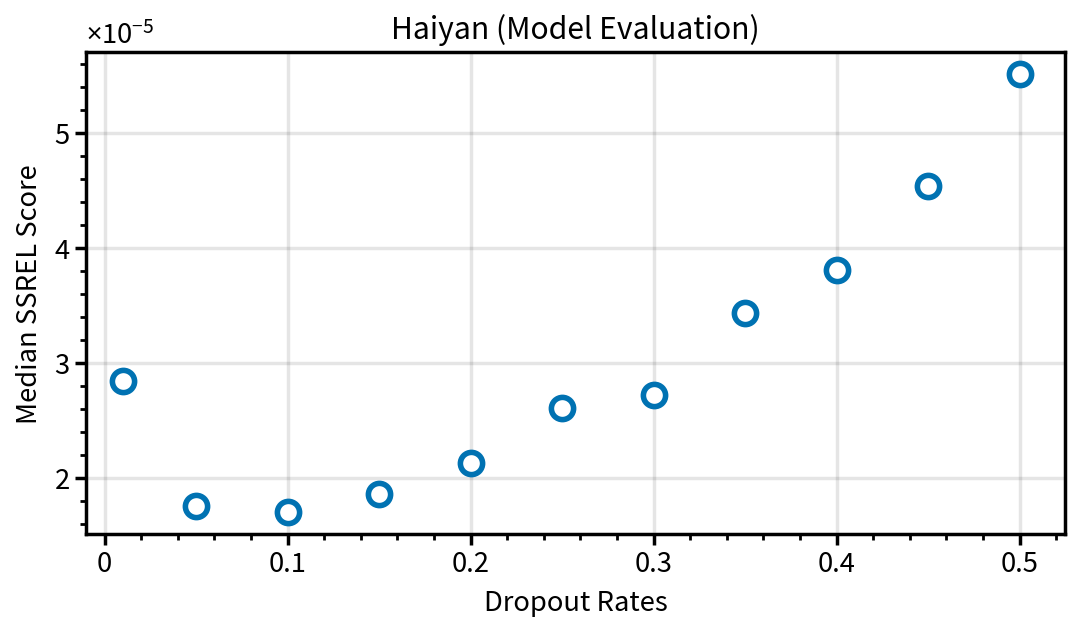

In [11]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=2.031)
axs[0].plot(droprates,[np.median(read_and_proc.flatten(ssrels[i])) for i in range(len(ssrels))],lw=0,marker='o',mfc='w',mew=2,markersize=8)
axs.format(xlabel='Dropout Rates',ylabel='Median SSREL Score',title='Haiyan (Model Evaluation)',xlim=[-0.01,0.525])#ylim=[2.5e-5,7.5e-5],xlim=[-0.01,0.485])
#plt.savefig('../analysis/pic/climateinfo/SSRELmedian.png',dpi=600)
plt.show()

In [12]:
np.asarray([np.min(np.asarray(obj)) for obj in ssrels[2]]).argmin(), np.asarray(ssrels[2][np.asarray([np.min(np.asarray(obj)) for obj in ssrels[2]]).argmin()]).argmin()

(1, 1)

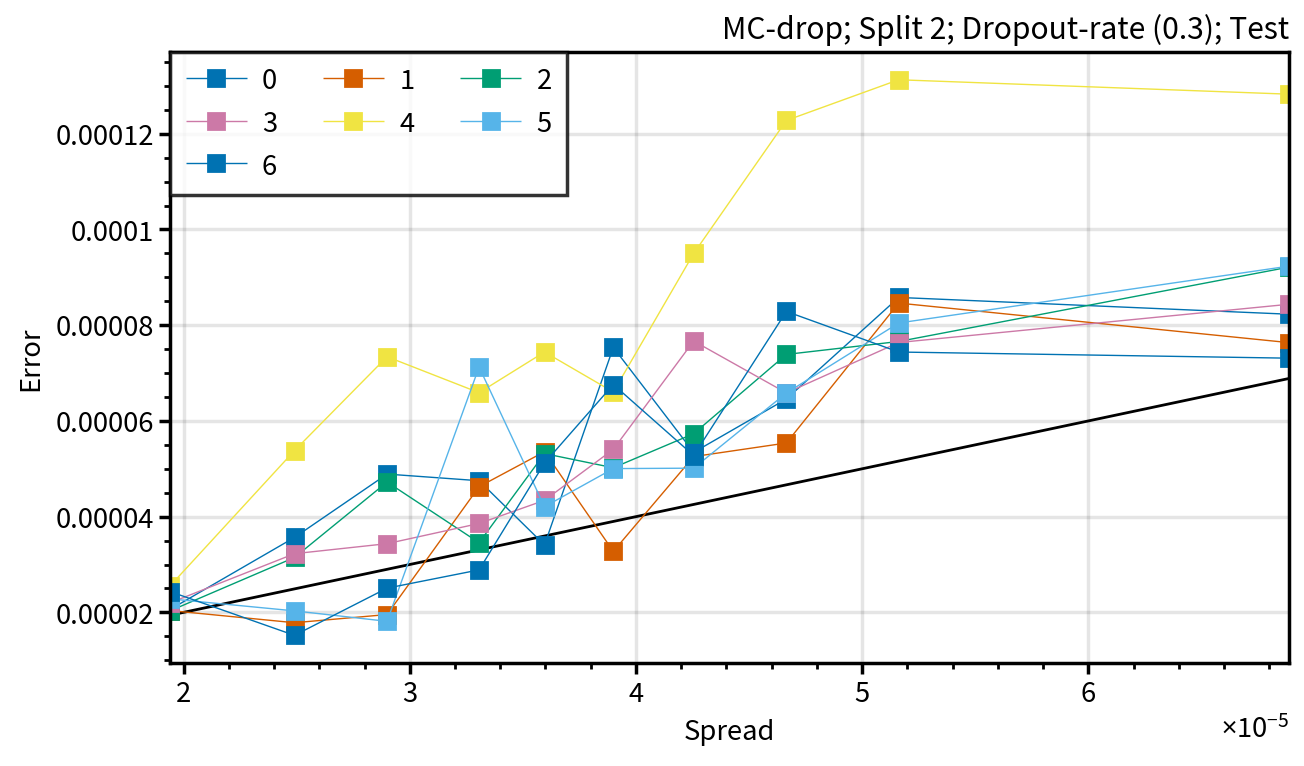

In [13]:
valsplit = 2
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.595,refaspect=1.831)
axs.plot(testst_flatten[2][valsplit][1:],testst_flatten[2][valsplit][1:],color='k',lw=1)
curvefin = curves_models[2][valsplit]
for i in range(7):
    axs.plot(testst_flatten[2][valsplit][1:],curvefin[i],marker='s',lw=0.5,label=i)
axs.legend(loc=1,ncol=3)
axs.format(xlabel='Spread',ylabel='Error',rtitle=f'MC-drop; Split {valsplit}; Dropout-rate ({droprates[6]}); Test')
plt.savefig('./pic/MCdropout_spreadskill_example.png',dpi=600)
plt.show()

In [14]:
folderpath=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/store/')
folderpath2=str('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/')
bestcal_exp = np.asarray([np.min(np.asarray(obj)) for obj in ssrels[2]]).argmin()
bestcal_exp_model = np.asarray(ssrels[2][np.asarray([np.min(np.asarray(obj)) for obj in ssrels[2]]).argmin()]).argmin()
X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtrain[int(bestcal_exp)],ytrain[int(bestcal_exp)])
X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[int(bestcal_exp)],yvalid[int(bestcal_exp)])
X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[int(bestcal_exp)],ytest[int(bestcal_exp)])

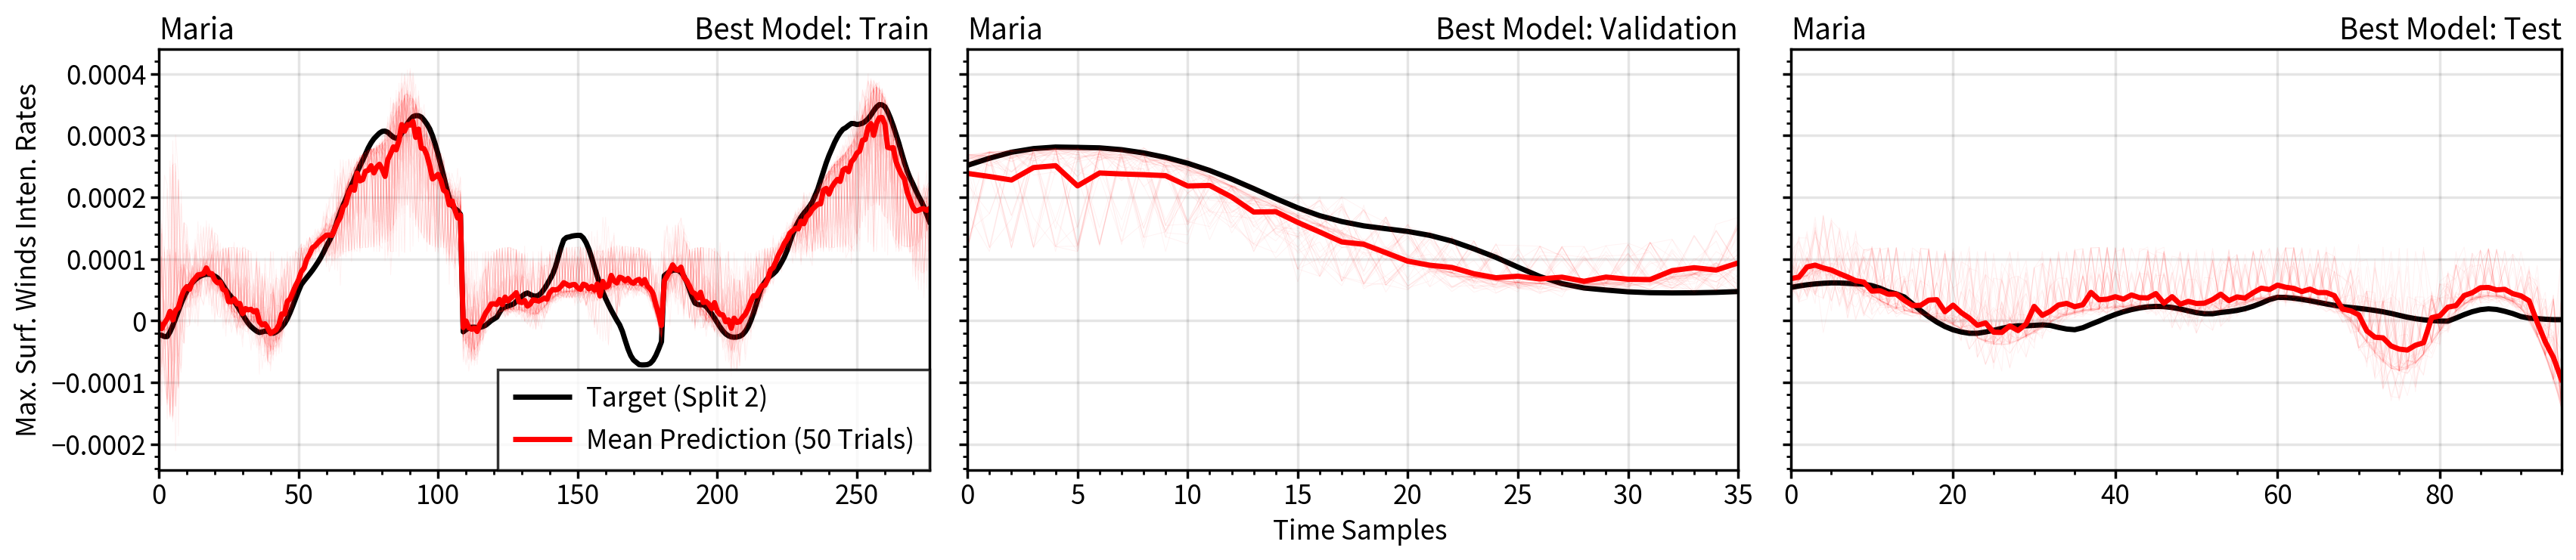

In [19]:
from sklearn.metrics import r2_score
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 14.05,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

#accesscode = float(droprates[ssrelminindex])
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=5.095,refaspect=1.831)
axs[0].plot(y_totrain,label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[0].plot(crps_store[0.1][bestcal_exp]['meantrains'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds =crps_store[0.1][bestcal_exp]['alltrains'][bestcal_exp_model]
for pred in allpreds:
    axs[0].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[0].legend(loc=4,ncols=1)
#r2_scoress = r2_score(y_totrain,rmse_performance[accesscode][int(valsplit)]['meantrains'][int(modelnum)])
axs[0].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Train')

axs[1].plot(y_tovalid,label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[1].plot(crps_store[0.1][bestcal_exp]['meanvals'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store[0.1][bestcal_exp]['allvals'][bestcal_exp_model]
for pred in allpreds:
    axs[1].plot(pred,c='r',lw=0.35,alpha=0.05)
#r2_scoress = r2_score(y_toval,rmse_performance[accesscode][int(valsplit)]['meanvals'][int(modelnum)])
axs[1].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Validation')#,rtitle='Optimal Longwave')
#plt.savefig('../analysis/pic/climateinfo/MCdropout_testskill_revised.png',dpi=600)

axs[2].plot(y_totest,label=f'Target (Split {valsplit})',c='k',lw=2.5)#79:132])
axs[2].plot(crps_store[0.1][bestcal_exp]['meantests'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])
allpreds = crps_store[0.1][bestcal_exp]['alltests'][bestcal_exp_model]
for pred in allpreds:
    axs[2].plot(pred,c='r',lw=0.35,alpha=0.05)
axs[2].format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Test')#,rtitle='Optimal Longwave')
plt.savefig('../analysis/pic/climateinfo/paper_fig2_maria_revised.png',dpi=600)
plt.show()

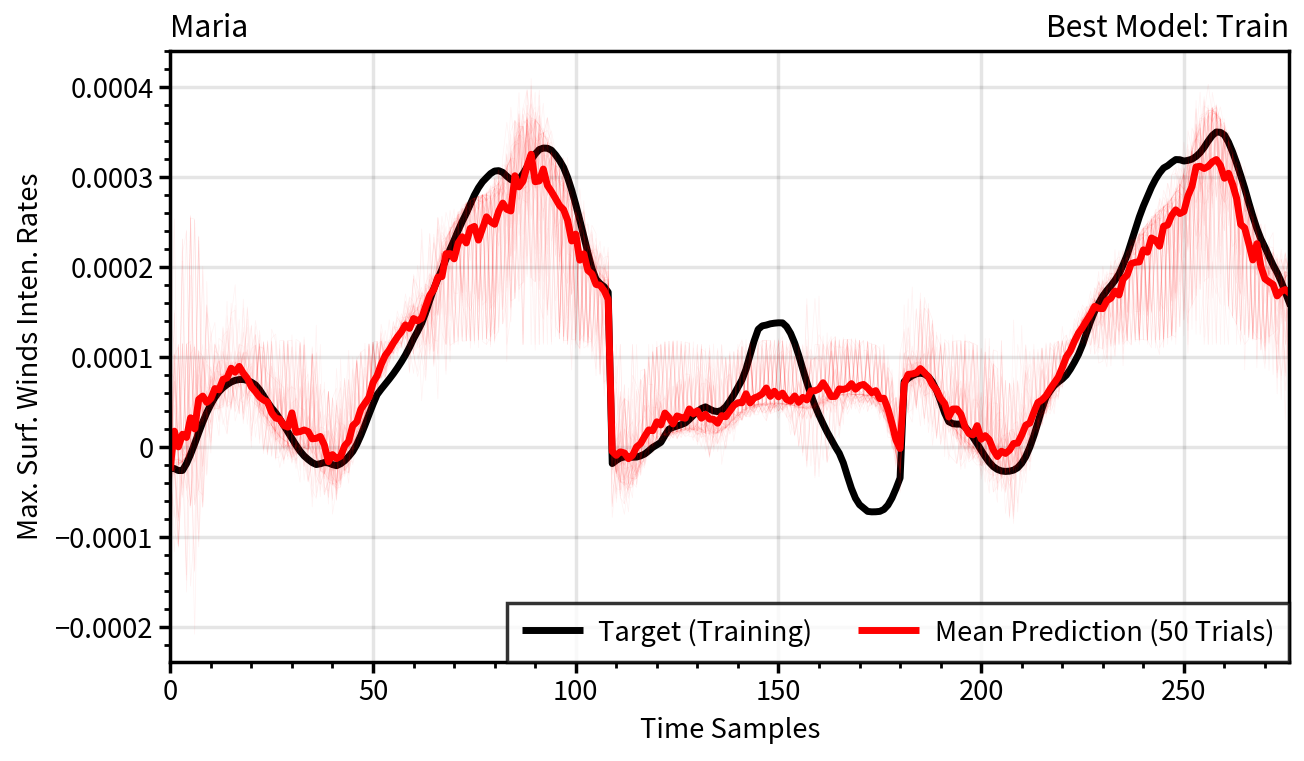

In [17]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.595,refaspect=1.831)
axs.plot(y_totrain,label='Target (Training)',c='k',lw=2.5)#79:132])
axs.plot(crps_store[0.1][bestcal_exp]['meantrains'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store[0.1][bestcal_exp]['alltrains'][bestcal_exp_model]
for pred in allpreds:
    axs.plot(pred,c='r',lw=0.25,alpha=0.05)

axs.legend(loc=4)
#r2_scoress = r2_score(y_totrain,rmse_performance[5][28]['meantrains'][2])
axs.format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Train') #({np.round(r2_scoress,decimals=2)})')#,rtitle='Optimal Longwave')
#plt.savefig('./pic/MCdropout_trainskill.png',dpi=600)
plt.show()

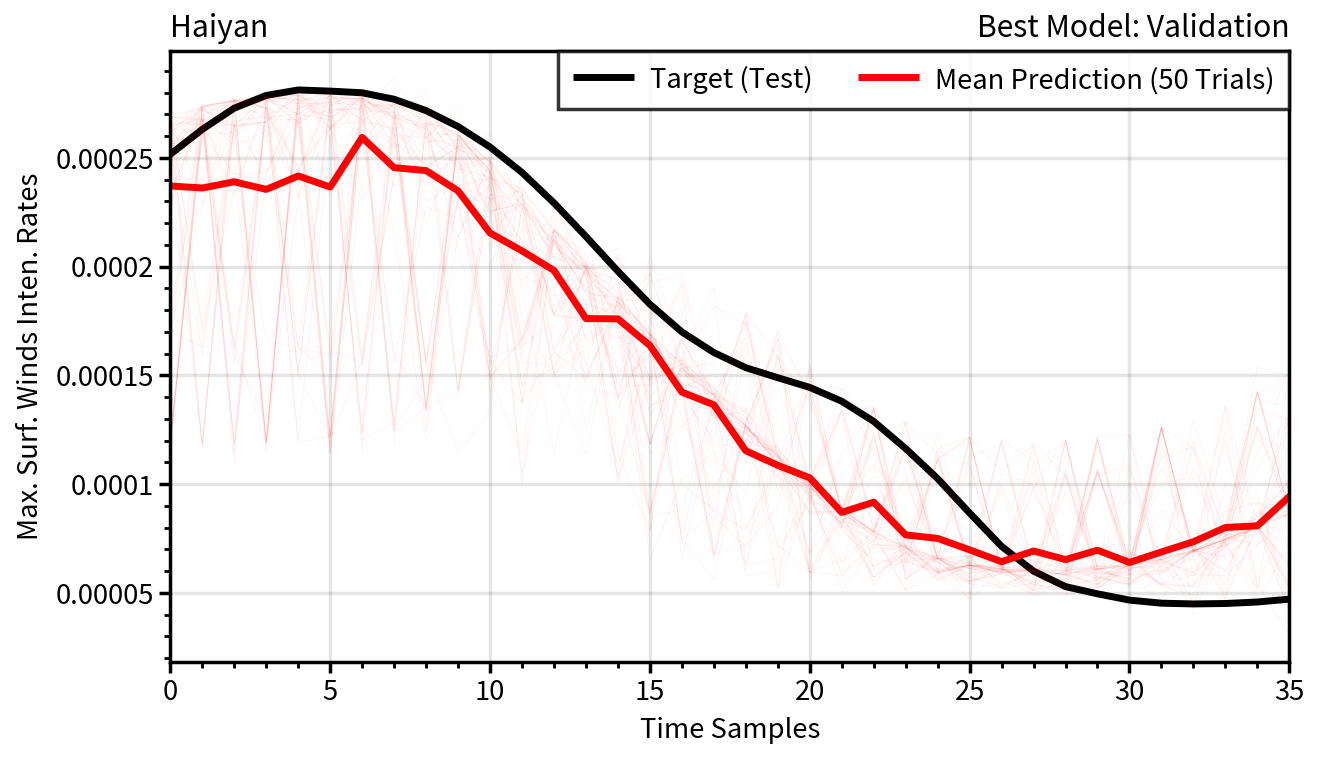

In [19]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.595,refaspect=1.831)
axs.plot(y_tovalid,label='Target (Test)',c='k',lw=2.5)#79:132])
axs.plot(crps_store[0.1][bestcal_exp]['meanvals'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store[0.1][bestcal_exp]['allvals'][bestcal_exp_model]
for pred in allpreds:
    axs.plot(pred,c='r',lw=0.35,alpha=0.05)

axs.legend(loc=1)
#r2_scoress = r2_score(y_totrain,rmse_performance[5][28]['meantrains'][2])
axs.format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Validation') #({np.round(r2_scoress,decimals=2)})')#,rtitle='Optimal Longwave')
plt.savefig('./pic/MCdropout_valskill.png',dpi=600)
plt.show()

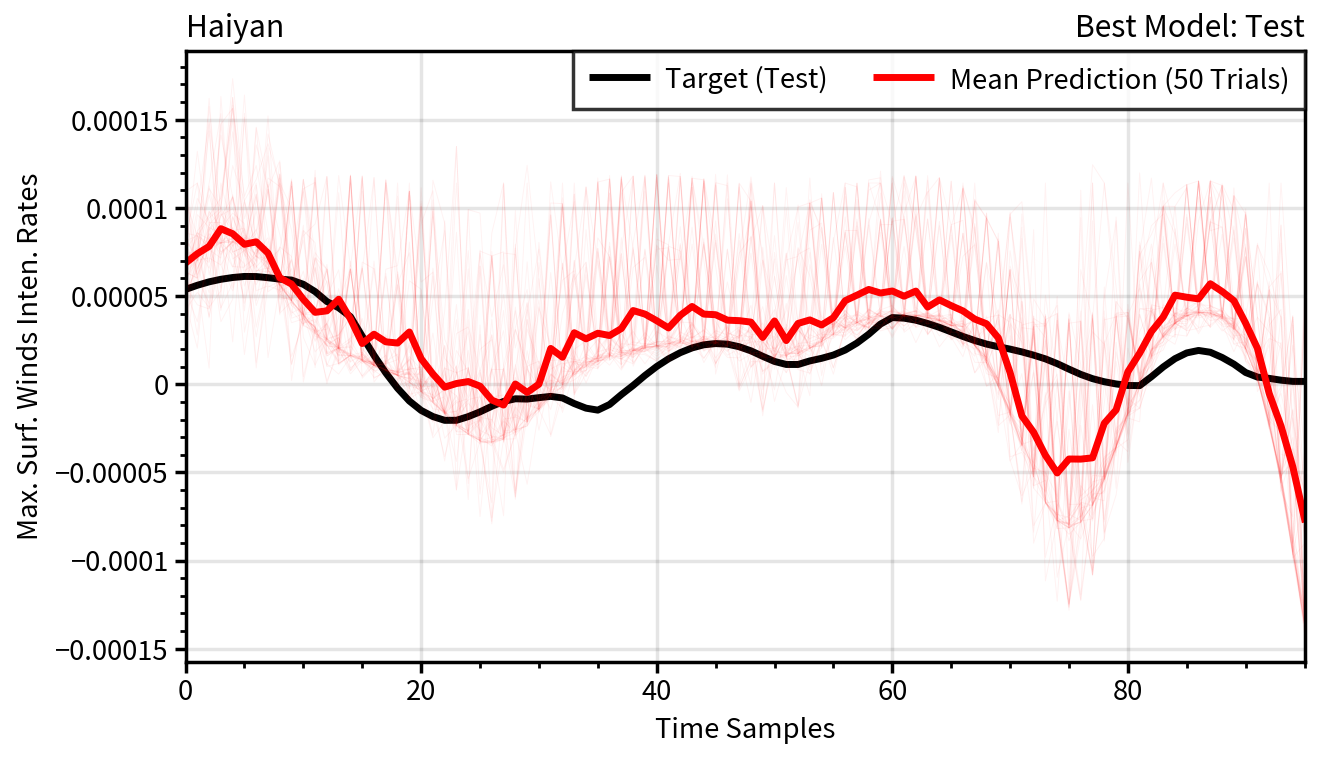

In [22]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.595,refaspect=1.831)
axs.plot(y_totest,label='Target (Test)',c='k',lw=2.5)#79:132])
axs.plot(crps_store[0.1][bestcal_exp]['meantests'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store[0.1][bestcal_exp]['alltests'][bestcal_exp_model]
for pred in allpreds:
    axs.plot(pred,c='r',lw=0.35,alpha=0.05)

axs.legend(loc=1)
#r2_scoress = r2_score(y_totrain,rmse_performance[5][28]['meantrains'][2])
axs.format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Haiyan',rtitle=f'Best Model: Test') #({np.round(r2_scoress,decimals=2)})')#,rtitle='Optimal Longwave')
plt.savefig('./pic/MCdropout_testskill.png',dpi=600)
plt.show()

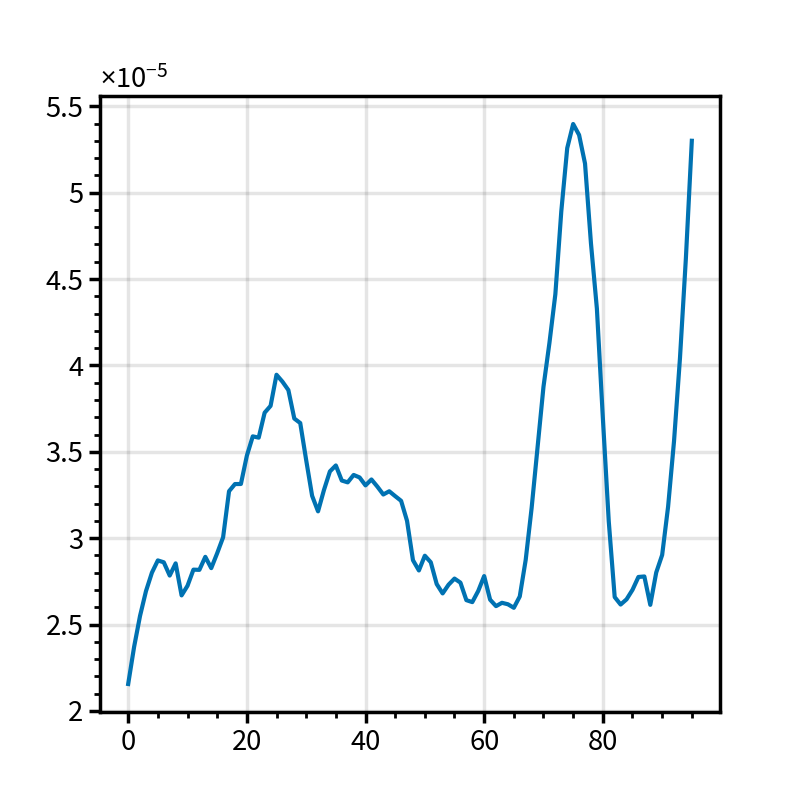

In [23]:
from scipy.signal import savgol_filter
plt.plot(savgol_filter(np.std(np.asarray(allpreds),axis=0),11,2))
plt.show()

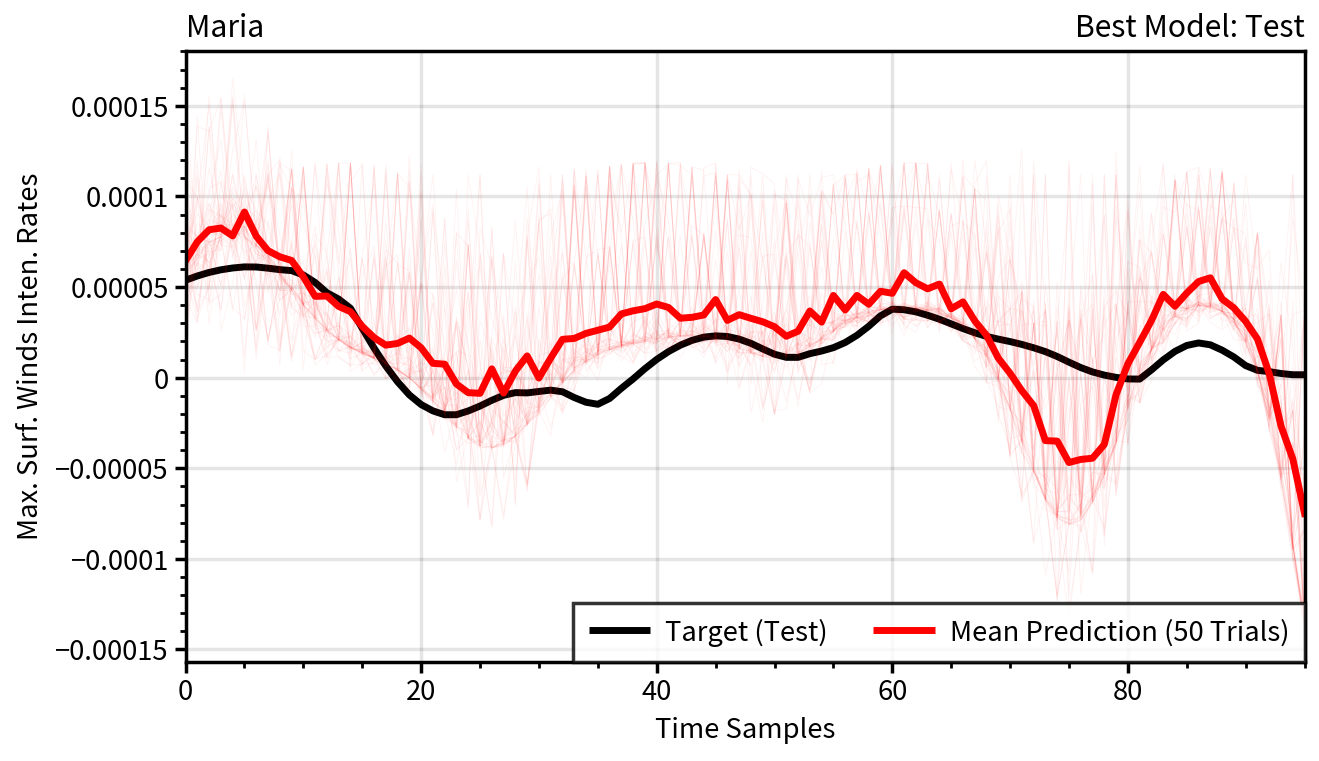

In [23]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=5.595,refaspect=1.831)
axs.plot(y_totest,label='Target (Test)',c='k',lw=2.5)#79:132])
axs.plot(crps_store[0.1][bestcal_exp]['meantests'][bestcal_exp_model],label='Mean Prediction (50 Trials)',c='r',lw=2.5)#79:132])

allpreds = crps_store[0.1][bestcal_exp]['alltests'][bestcal_exp_model]
for pred in allpreds:
    axs.plot(pred,c='r',lw=0.35,alpha=0.05)

axs.legend(loc=4)
#r2_scoress = r2_score(y_totrain,rmse_performance[5][28]['meantrains'][2])
axs.format(xlabel='Time Samples',ylabel='Max. Surf. Winds Inten. Rates',ltitle='Maria',rtitle=f'Best Model: Test') #({np.round(r2_scoress,decimals=2)})')#,rtitle='Optimal Longwave')
#plt.savefig('./pic/MCdropout_testkill.png',dpi=600)
plt.show()

# Optimal Structures

In [24]:
calc_device='cpu'
class OptimMLR_lwsw_3D_ts_dropout_small_dropemulate(torch.nn.Module):
    def __init__(self,droprate):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_lwsw_3D_ts_dropout_small_dropemulate, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [10,10]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dropout1 = torch.nn.Dropout(droprate)
        self.dropout2 = torch.nn.Dropout(droprate)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,54,26,50,75,12,10,10]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        X_lwc = self.dropout1(X_lw)
        #bestlw = self.dense1(X_lwc)
        X_swc = self.dropout2(X_sw)
        #bestsw = self.dense2(X_swc)
        return X_lwc,X_swc
    
class OptimMLR_lwsw_3D_ts_dropout_small2(torch.nn.Module):
    def __init__(self,droprate):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_lwsw_3D_ts_dropout_small2, self).__init__()
        self.dropout3 = torch.nn.Dropout(droprate)
        self.denseout = torch.nn.Linear(2,1)#106)
        
    def forward(self,X):
        bestPC = self.dropout3(X)
        outpred = self.denseout(bestPC)
        return outpred

In [25]:
from copy import deepcopy
def get_MLdrop_structures(bestmodel=None,pcastore=None,standard=True,shape3D=[10,360,208],Xtest=None,ytest=None):
    # First Model
    model = OptimMLR_lwsw_3D_ts_dropout_small_dropemulate(0.25)
    model_dict = model.state_dict()
    pretrained_dict = bestmodel.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    
    test_Xtensor = torch.FloatTensor(Xtest).to(calc_device)
    test_ytensor = torch.FloatTensor(ytest).to(calc_device)
    lwdrop,swdrop = model.train()(test_Xtensor)
    lwdrop,swdrop = lwdrop.detach().numpy(),swdrop.detach().numpy()
    weights = model_outweights(model)
    
    normpattern_SW,normpattern_LW,weightsstore = [],[],[]
    for i in range(len(lwdrop)):
        LWweights = deepcopy(weights[0][0].detach().numpy())
        SWweights = deepcopy(weights[0][1].detach().numpy())
        LW_zeroindices,SW_zeroindices = list(np.where(lwdrop[i,...]==0)[0]),list(np.where(swdrop[i,...]==0)[0])
        np.put(LWweights,LW_zeroindices,[0 for _ in range(len(LW_zeroindices))])
        np.put(SWweights,SW_zeroindices,[0 for _ in range(len(SW_zeroindices))])
        weightsstore.append({'LW':LWweights,'SW':SWweights})
        
        if standard:
            TEST_LW = (LWweights)/((np.sqrt(np.sum(LWweights**2))))
            TEST_SW = (SWweights)/((np.sqrt(np.sum(SWweights**2))))
            normpattern_SW.append(np.squeeze(np.dot(TEST_SW,pcastore['sw'].components_[:10,:])).reshape(shape3D[0],shape3D[1],shape3D[2]))
            normpattern_LW.append(np.squeeze(np.dot(TEST_LW,pcastore['lw'].components_[:10,:])).reshape(shape3D[0],shape3D[1],shape3D[2]))
    return normpattern_LW,normpattern_SW,weightsstore

def model_outweights_all(model=None):
    params,names = [],[]
    for name, param in model.named_parameters():
        params.append(param)
        names.append(name)
        #if ".weight" not in name:
        #    continue            
        #else:
        #    params.append(param)
        #    names.append(name)
    return params, names

def model_outweights(model=None):
    params,names = [],[]
    for name, param in model.named_parameters():
        if ".weight" not in name:
            continue            
        else:
            params.append(param)
            names.append(name)
    return params, names

In [26]:
exp_split = 2
bestmodel = crps_store[0.1][exp_split]['models'][0][0]
bestweights,bestname = model_outweights_all(bestmodel)
X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xvalid[exp_split],yvalid[exp_split])
X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2).delete_padding(Xtest[exp_split],ytest[exp_split])

In [27]:
LWstructures, SWstructures, weightss = [],[],[]
for _ in range(20):
    a,b,c = get_MLdrop_structures(bestmodel,pcastore,True,[39,360,200],X_totest,y_totest)
    LWstructures.append(a)
    SWstructures.append(b)
    weightss.append(c)

In [28]:
LWstructures_mean = np.nanmean(np.asarray([np.nanmean(np.asarray(LWstructures[i])[10:20,...],axis=0) for i in range(20)]),axis=0)
SWstructures_mean = np.nanmean(np.asarray([np.nanmean(np.asarray(SWstructures[i])[10:20,...],axis=0) for i in range(20)]),axis=0)
LWstructures_std = np.nanstd(np.asarray([np.nanmean(np.asarray(LWstructures[i])[10:20,...],axis=0) for i in range(20)]),axis=0)
SWstructures_std = np.nanstd(np.asarray([np.nanmean(np.asarray(SWstructures[i])[10:20,...],axis=0) for i in range(20)]),axis=0)

In [29]:
from scipy.ndimage import gaussian_filter

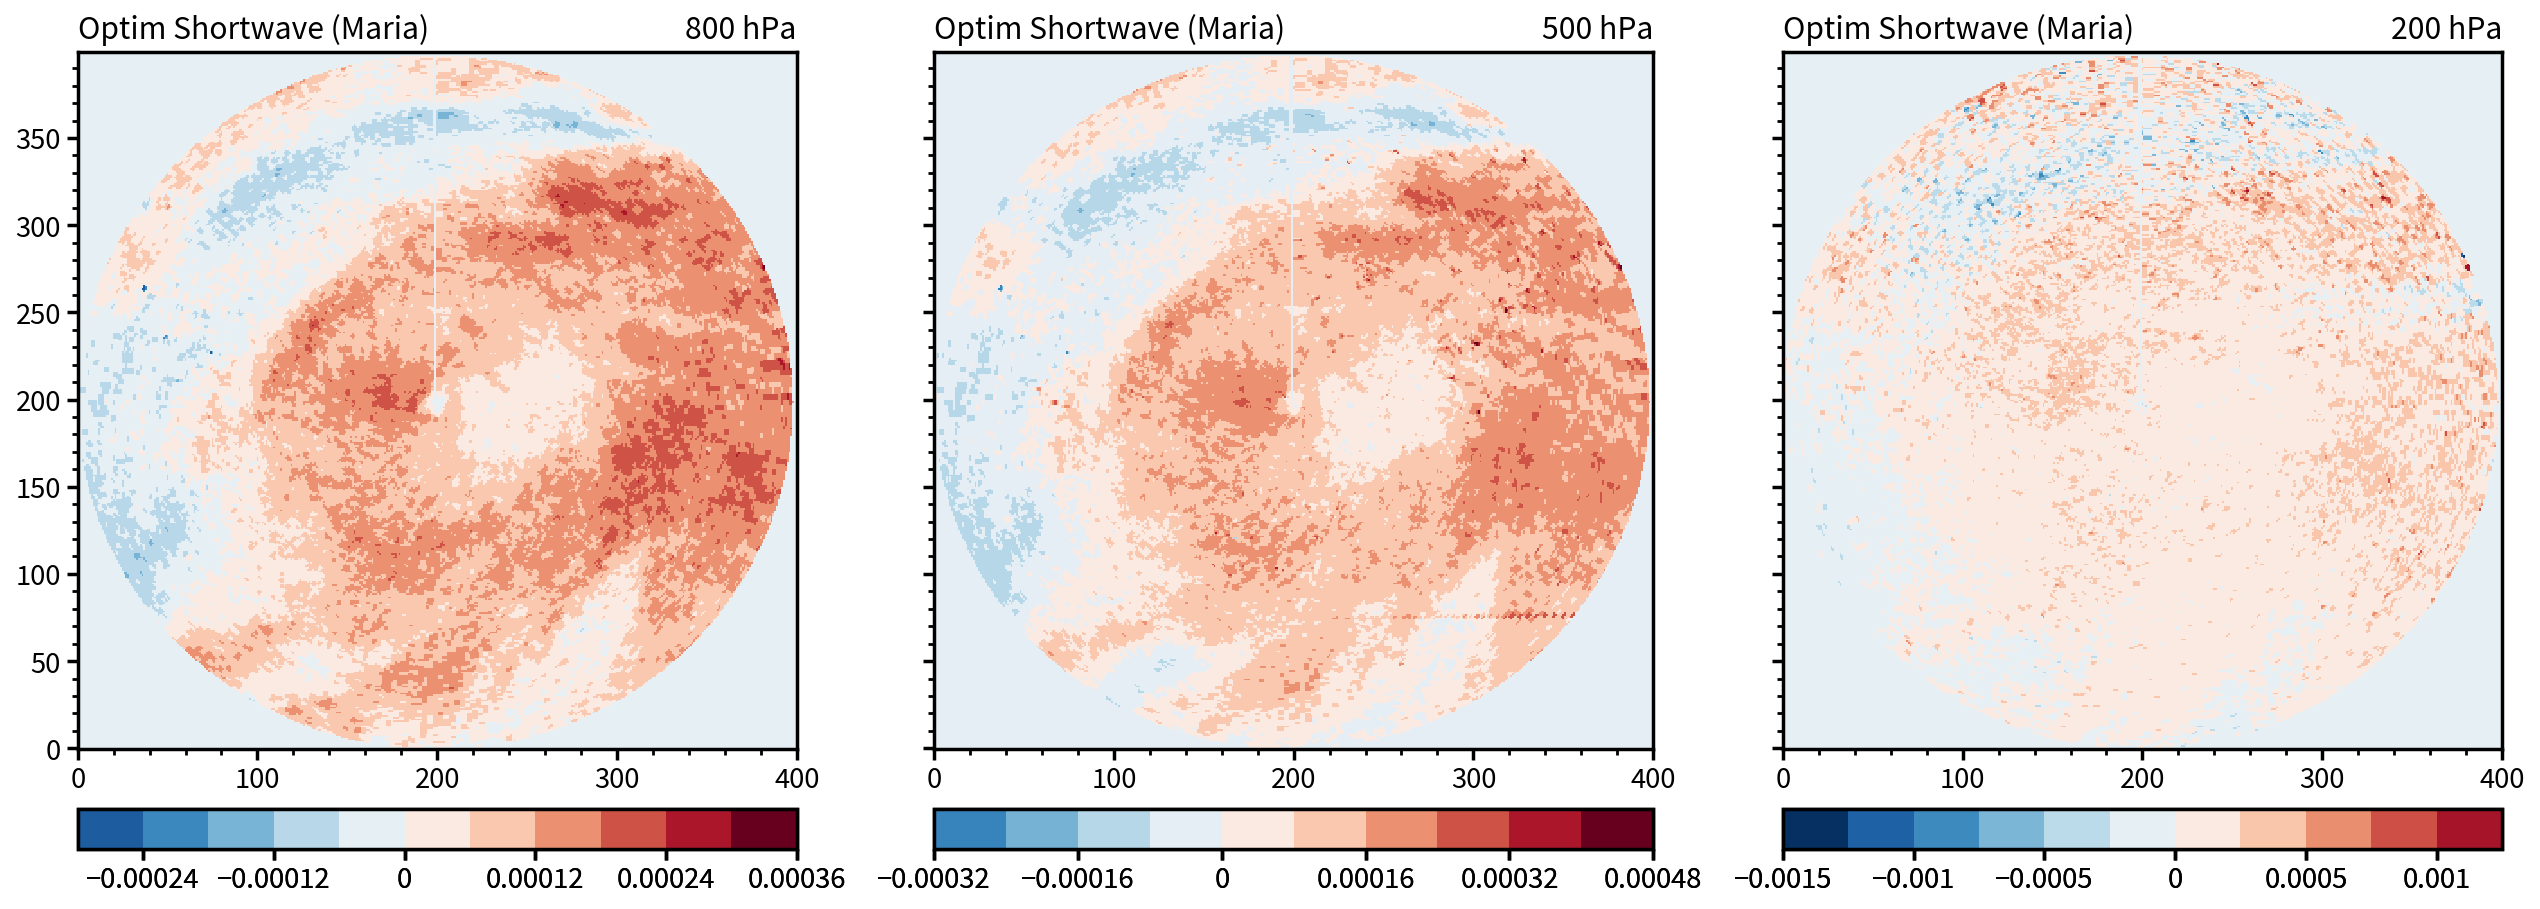

In [31]:
def normalize(array):
    return (array-np.nanmean(array))/np.nanstd(array)
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
pressurelevel = [800,500,200]

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
for i,obj in enumerate([2,5,-2]):
    #maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.65,.65),cmap='BuRd',vmin=-3,vmax=3)
    #maps = axs[i].pcolormesh(np.ma.masked_where(masks[i].mask,(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(LWstructures_mean)[i,...],ANGLE,True,False))))),cmap='BuRd')
    maps = axs[i].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.asarray(SWstructures_mean)[i,...],ANGLE,True,False)))),cmap='BuRd')
    # hatches
    #stdd = np.nanstd(np.abs(np.asarray(test_toavg)[:,5,int(obj),...]))#,45)
    #aaaa = np.ma.masked_inside((np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(np.asarray(test_toavg),axis=0)[5,int(obj),...],ANGLE,True,False)))),-stdd,stdd).mask
    #axs[i].contourf(aaaa.astype(int),levels=[0,0.5,1],hatches=["////","",""],alpha=0)
    # format
    axs[i].format(ltitle='Optim Shortwave (Maria)',rtitle=f'{pressurelevel[i]} hPa',xlim=[0,400])
    axs[i].colorbar(maps,loc='b')
plt.savefig('./pic/maria_optimSW_mean.png',dpi=600)
plt.show()

In [167]:
masks = [np.ma.masked_greater(np.fliplr(np.flipud(read_and_proc.proc_tocart(LWstructures_std[i,...],ANGLE,True,False))),\
                             np.nanpercentile(np.fliplr(np.flipud(read_and_proc.proc_tocart(LWstructures_std[i,...],ANGLE,True,False))),30)) for i in [2,5,-2]]

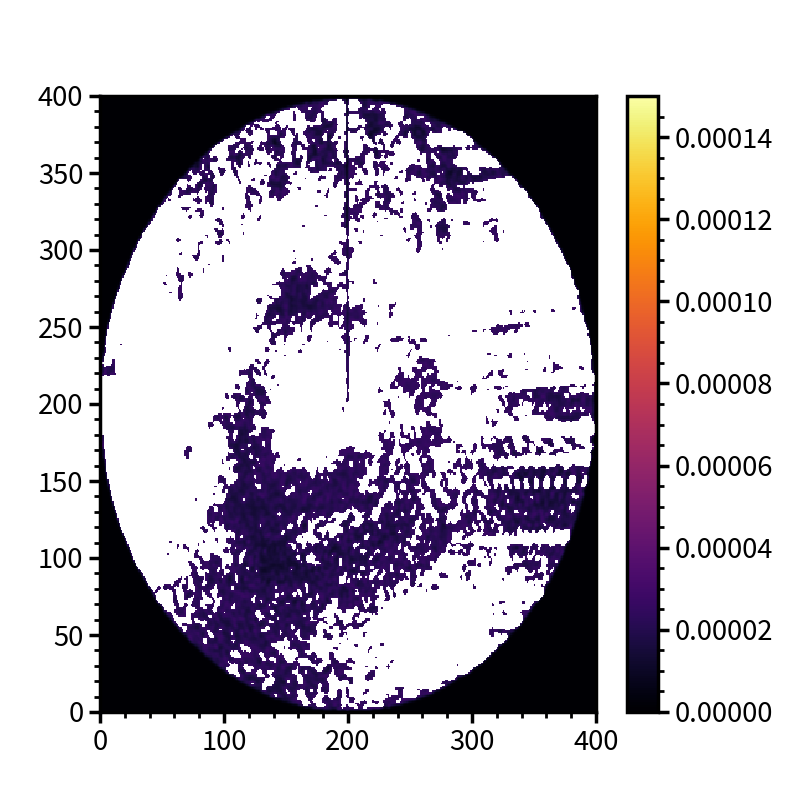

In [148]:
plt.pcolormesh(np.ma.masked_greater(gaussian_filter(np.fliplr(np.flipud(read_and_proc.proc_tocart(LWstructures_std[5,...],ANGLE,True,False))),1.05),2.686184543803084e-05),cmap='inferno',vmin=0,vmax=0.00015)
plt.colorbar()
plt.show()

In [147]:
np.nanpercentile(np.fliplr(np.flipud(read_and_proc.proc_tocart(LWstructures_std[5,...],ANGLE,True,False))),50)

2.686184543803084e-05